In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np

In [2]:
# Set the path containing the results of all experiments
RESULTS_PATH = Path('./results')

In [3]:
sns.set_theme(
    context='notebook',
    style='white',
    palette='flare',
);
gridcolor = '#d1d1cf'

In [4]:
def read_outputfile(fp: Path, runs: list[dict]) -> None:
    with open(fp, 'r') as f:
        content = f.read()
    lines = content.split('\n')

    for line in lines:
        if not line.startswith('data'):
            continue
        run = {item.split(' ')[0]: item.split(' ')[1] for item in line.split(': ')[1].split('\t')[:-1]}
        run['data'] = line.split(': ')[0]
        run['exp'] = fp.parent.stem
        run['n'] = int(fp.stem.split('-')[2][6:])
        run['BH'] = True if run['BH'] == '1' else False
        run['N'] = int(run['N'])
        run['ITERS'] = int(run['ITERS'])
        run['TIME'] = float(run['TIME'])
        run.pop('DT')
        run.pop('SIZE')
        run.pop('THETA')
        runs.append(run)

## Strong scaling

In [5]:
runs = []
for file in RESULTS_PATH.rglob('mpi-strongscaling-*.out'):
    read_outputfile(file, runs)

print(f'There are {len(runs)} runs.')

There are 1050 runs.


In [6]:
strongscaling = pd.DataFrame(runs)

In [7]:
strongscaling.query('n == 1').query('N == 100')

,BH,N,ITERS,TIME,data,exp,n
222,True,100,20,0.000983,data/galaxy.txt,20231229184416-6,1
285,True,100,20,0.000985,data/galaxy.txt,20231229184416-1,1
348,True,100,20,0.000958,data/galaxy.txt,20231229184416-8,1
411,True,100,20,0.000989,data/galaxy.txt,20231229184416-9,1
474,True,100,20,0.000964,data/galaxy.txt,20231229184416-0,1
537,True,100,20,0.000992,data/galaxy.txt,20231229184416-7,1
852,True,100,20,0.000874,data/galaxy.txt,20231229184416-2,1
915,True,100,20,0.000997,data/galaxy.txt,20231229184416-5,1
978,True,100,20,0.000954,data/galaxy.txt,20231229184416-4,1
1041,True,100,20,0.000866,data/galaxy.txt,20231229184416-3,1


In [8]:
strongscaling = pd.DataFrame(runs)

# Calculate t1 for each group
t1 = strongscaling.groupby(by=['data', 'N', 'ITERS']).apply(lambda rows: rows[rows.n==1].TIME.median())
t1.name = 't1'
strongscaling = strongscaling.merge(right=t1.reset_index(), on=['data', 'N', 'ITERS'], how='left')
# Calculate speedup
strongscaling['S(n)'] = strongscaling.t1 / strongscaling.TIME

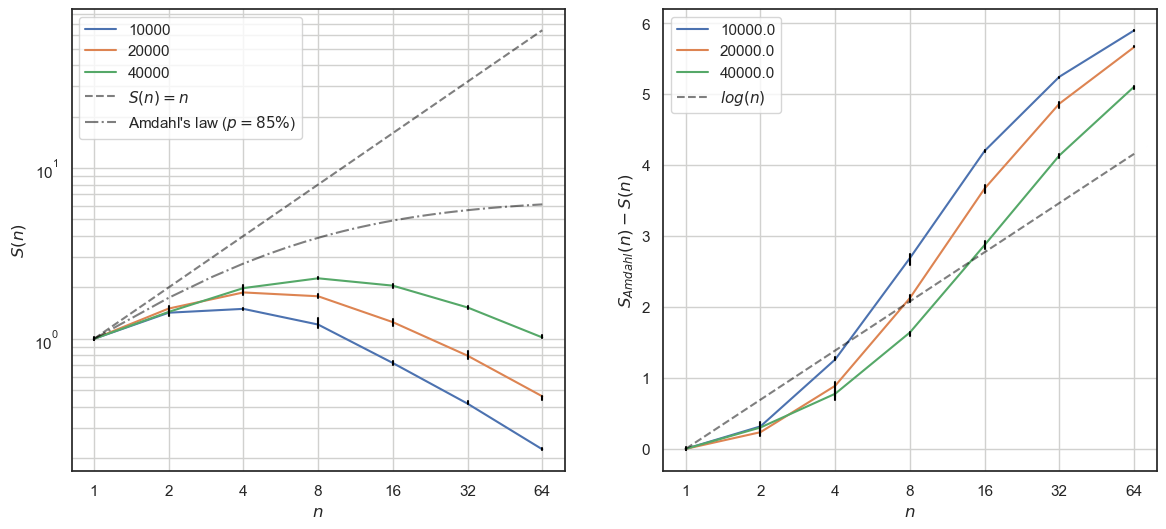

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

p = .85

# Speedup
sns.lineplot(
    ax=axs[0],
    data=strongscaling.query('N > 5000').query('ITERS == 20'),
    x='n', y='S(n)',
    # kind='line',
    hue='N',
    # col='ITERS',
    palette='deep',
    errorbar=('ci', 90),
    estimator='median',
    err_style='bars',
    err_kws={'ecolor': 'black'},
);
# Ideal lines
n = np.arange(1, 65)
ideal = n
amdahl = 1 / ((1 - p) + p / n)
h1, = axs[0].plot(n, ideal, '--k', alpha=0.5);
h2, = axs[0].plot(n, amdahl, '-.k', alpha=0.5);
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles + [h1, h2], labels + ['$S(n) = n$', f'Amdahl\'s law ($p={p*100:.0f}\%$)']);
# Grids
axs[0].grid(True, axis='y', which="both", ls="-", c=gridcolor)
axs[0].grid(True, axis='x', which="major", ls="-", c=gridcolor)
# Scale
axs[0].set(xscale='log', yscale='log')
# Ticks
axs[0].set_xticks(strongscaling.n.unique())
axs[0].set_xticklabels(strongscaling.n.unique())
# Labels
axs[0].set(xlabel='$n$', ylabel='$S(n)$');

# Discrepency
sns.lineplot(
    ax=axs[1],
    data=strongscaling.query('N > 5000').query('ITERS == 20'),
    x='n',
    y=(1 / ((1 - p) + p / strongscaling.n) - strongscaling['S(n)']),
    hue='N',
    palette='deep',
    errorbar=('ci', 90),
    estimator='median',
    err_style='bars',
    err_kws={'ecolor': 'black'},
    legend=True,
)
# Ideal line
n = np.arange(1, 65)
ideal = np.log(n)
h1, = axs[1].plot(n, ideal, '--k', alpha=0.5);
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles + [h1], labels + ['$log(n)$']);
# Grids
axs[1].grid(True, axis='y', which="both", ls="-", c=gridcolor)
axs[1].grid(True, axis='x', which="major", ls="-", c=gridcolor)
# Scale
axs[1].set(xscale='log')
# Ticks
axs[1].set_xticks(strongscaling.n.unique())
axs[1].set_xticklabels(strongscaling.n.unique())
# Labels
axs[1].set(xlabel='$n$', ylabel='$S_{Amdahl}(n) - S(n)$');

## Weak scaling

In [10]:
runs = []
for file in RESULTS_PATH.rglob('mpi-weakscaling-*.out'):
    read_outputfile(file, runs)

print(f'There are {len(runs)} runs.')

There are 140 runs.


In [11]:
weakscaling = pd.DataFrame(runs)

# Calculate t_1 for each group
t1 = weakscaling.groupby(by=['data', 'ITERS']).apply(lambda rows: rows[rows.n==1].TIME.mean())
t1.name = 't1'
weakscaling = weakscaling.merge(right=t1.reset_index(), on=['data', 'ITERS'], how='left')
# Calculate efficiency
weakscaling['E(n)'] = (weakscaling.t1 / weakscaling.TIME)

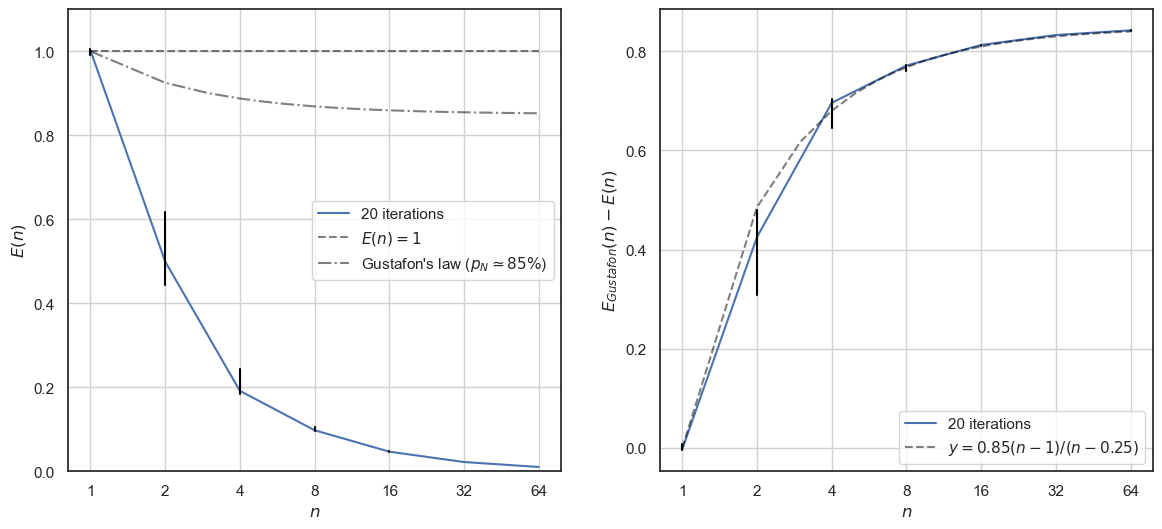

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

p = .85

# Efficiency
sns.lineplot(
    ax=axs[0],
    data=weakscaling.query('ITERS == 20'),
    x='n', y='E(n)',
    hue='ITERS',
    palette='deep',
    estimator='median',
    errorbar=('ci', 90),
    err_style='bars',
    err_kws={'ecolor': 'black'},
);
# Ideal line
n = np.arange(1, 65)
ideal = np.ones(64)
gustafon = (1 + (n - 1) * p) / n
h1, = axs[0].plot(n, ideal, '--k', alpha=0.5);
h2, = axs[0].plot(n, gustafon, '-.k', alpha=0.5);
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles + [h1, h2], ['20 iterations', '$E(n) = 1$', f'Gustafon\'s law ($p_N\simeq{p*100:.0f}\%$)']);
# Grids
axs[0].grid(True, axis='y', which="both", ls="-", c=gridcolor)
axs[0].grid(True, axis='x', which="major", ls="-", c=gridcolor)
# Scale
axs[0].set(xscale='log', ylim=[0, 1.1])
# Ticks
axs[0].set_xticks(strongscaling.n.unique())
axs[0].set_xticklabels(strongscaling.n.unique())
# Labels
axs[0].set(xlabel='$n$', ylabel='$E(n)$');

# Discrepency
sns.lineplot(
    ax=axs[1],
    data=weakscaling.query('ITERS == 20'),
    x='n',
    y=((1 + (weakscaling.n - 1) * p) / weakscaling.n - weakscaling['E(n)']),
    hue='ITERS',
    palette='deep',
    errorbar=('ci', 90),
    estimator='median',
    err_style='bars',
    err_kws={'ecolor': 'black'},
)
# Ideal line
n = np.arange(1, 65)
ideal = .85 * (n - 1) / (n - .25)
h1, = axs[1].plot(n, ideal, '--k', alpha=0.5);
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles + [h1], ['20 iterations', '$y = 0.85 (n-1) / (n-0.25)$']);
# Grids
axs[1].grid(True, axis='y', which="both", ls="-", c=gridcolor)
axs[1].grid(True, axis='x', which="major", ls="-", c=gridcolor)
# Scale
axs[1].set(xscale='log')
# Ticks
axs[1].set_xticks(strongscaling.n.unique())
axs[1].set_xticklabels(strongscaling.n.unique())
# Labels
axs[1].set(xlabel='$n$', ylabel='$E_{Gustafon}(n) - E(n)$');